In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.umath_tests import inner1d
import os
import sys
import SimpleITK as sitk

C:\Users\r778e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  This is separate from the ipykernel package so we can avoid doing imports until


In [160]:
def load_patient(patient_id,label=True):
    pat_id=patient_id
    if not label:
        filename_ct=r"D:\data_set_no_augmentation\HeadAndNeck_anonymous-%i.mha" %pat_id
        ct_image = sitk.ReadImage(filename_ct)
        npa = sitk.GetArrayViewFromImage(ct_image)
        return ct_image,npa

    else:
        filename_label=r"D:\data_set_no_augmentation\HeadAndNeck_anonymous-%i-label.mha" %pat_id
        ct_label = sitk.ReadImage(filename_label)
        npa = sitk.GetArrayViewFromImage(ct_label)
        filename_ct=r"D:\data_set_no_augmentation\HeadAndNeck_anonymous-%i.mha" %pat_id
        ct_image = sitk.ReadImage(filename_ct)
        return ct_image,ct_label,npa




In [161]:
patient_1,_=load_patient(patient_id=1,label=False)
patient_2,_=load_patient(patient_id=2,label=False)

In [163]:
def augment_images_intensity(image_list, output_prefix, output_suffix):
    '''
    Generate intensity modified images from the originals.
    Args:
        image_list (iterable containing SimpleITK images): The images which we whose intensities we modify.
        output_prefix (string): output file name prefix (file name: output_prefixi_FilterName.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefixi_FilterName.output_suffix).
    '''

    # Create a list of intensity modifying filters, which we apply to the given images
    filter_list = []
    
    # Smoothing filters

    
    filter_list.append(sitk.BilateralImageFilter())
    filter_list[-1].SetDomainSigma(4.0)
    filter_list[-1].SetRangeSigma(8.0)

    
    # Noise filters using default settings
    
    # Filter control via SetMean, SetStandardDeviation.
    filter_list.append(sitk.AdditiveGaussianNoiseImageFilter())

    # Filter control via SetProbability
    filter_list.append(sitk.SaltAndPepperNoiseImageFilter())
    
    # Filter control via SetScale
    filter_list.append(sitk.ShotNoiseImageFilter())
    
    # Filter control via SetStandardDeviation
    filter_list.append(sitk.SpeckleNoiseImageFilter())

    filter_list.append(sitk.AdaptiveHistogramEqualizationImageFilter())
    filter_list[-1].SetAlpha(1.0)
    filter_list[-1].SetBeta(0.0)

    filter_list.append(sitk.AdaptiveHistogramEqualizationImageFilter())
    filter_list[-1].SetAlpha(0.0)
    filter_list[-1].SetBeta(1.0)
    
    aug_image_lists = [] # Used only for display purposes in this notebook.
    for i,img in enumerate(image_list):
        aug_image_lists.append([f.Execute(img) for f in filter_list])            
        for aug_image,f in zip(aug_image_lists[-1], filter_list):
            sitk.WriteImage(aug_image, output_prefix + str(i) + '_' +
                            f.GetName() + '.' + output_suffix)


In [331]:
data=[patient_3_label,patient_4_label]

In [332]:
OUTPUT_DIR=r"C:\Users\r778e\Desktop"
augment_images_intensity(data,os.path.join(OUTPUT_DIR, 'aug'),'mha')

In [179]:
patient_3_image,patient_3_label,_=load_patient(patient_id=3,label=True)
patient_4_image,patient_4_label,_=load_patient(patient_id=4,label=True)

In [235]:
data=[patient_3_label,patient_4_label]

In [236]:
def parameter_space_regular_grid_sampling(*transformation_parameters):
    '''
    Create a list representing a regular sampling of the parameter space.     
    Args:
        *transformation_paramters : two or more numpy ndarrays representing parameter values. The order 
                                    of the arrays should match the ordering of the SimpleITK transformation 
                                    parameterization (e.g. Similarity2DTransform: scaling, rotation, tx, ty)
    Return:
        List of lists representing the regular grid sampling.
        
    Examples:
        #parameterization for 2D translation transform (tx,ty): [[1.0,1.0], [1.5,1.0], [2.0,1.0]]
        >>>> parameter_space_regular_grid_sampling(np.linspace(1.0,2.0,3), np.linspace(1.0,1.0,1))        
    '''
    return [[np.asscalar(p) for p in parameter_values] 
            for parameter_values in np.nditer(np.meshgrid(*transformation_parameters))]

def similarity3D_parameter_space_regular_sampling(thetaX, thetaY, thetaZ, tx, ty, tz, scale):
    '''
    Create a list representing a regular sampling of the 3D similarity transformation parameter space. As the
    SimpleITK rotation parameterization uses the vector portion of a versor we don't have an 
    intuitive way of specifying rotations. We therefor use the ZYX Euler angle parametrization and convert to
    versor.
    Args:
        thetaX, thetaY, thetaZ: numpy ndarrays with the Euler angle values to use.
        tx, ty, tz: numpy ndarrays with the translation values to use.
        scale: numpy array with the scale values to use.
    Return:
        List of lists representing the parameter space sampling (vx,vy,vz,tx,ty,tz,s).
    '''
    return [list(eul2quat(parameter_values[0],parameter_values[1], parameter_values[2])) + 
            [np.asscalar(p) for p in parameter_values[3:]] for parameter_values in np.nditer(np.meshgrid(thetaX, thetaY, thetaZ, tx, ty, tz, scale))]
    

def eul2quat(ax, ay, az, atol=1e-8):
    '''
    Translate between Euler angle (ZYX) order and quaternion representation of a rotation.
    Args:
        ax: X rotation angle in radians.
        ay: Y rotation angle in radians.
        az: Z rotation angle in radians.
        atol: tolerance used for stable quaternion computation (qs==0 within this tolerance).
    Return:
        Numpy array with three entries representing the vectorial component of the quaternion.

    '''
    # Create rotation matrix using ZYX Euler angles and then compute quaternion using entries.
    cx = np.cos(ax)
    cy = np.cos(ay)
    cz = np.cos(az)
    sx = np.sin(ax)
    sy = np.sin(ay)
    sz = np.sin(az)
    r=np.zeros((3,3))
    r[0,0] = cz*cy 
    r[0,1] = cz*sy*sx - sz*cx
    r[0,2] = cz*sy*cx+sz*sx     

    r[1,0] = sz*cy 
    r[1,1] = sz*sy*sx + cz*cx 
    r[1,2] = sz*sy*cx - cz*sx

    r[2,0] = -sy   
    r[2,1] = cy*sx             
    r[2,2] = cy*cx

    # Compute quaternion: 
    qs = 0.5*np.sqrt(r[0,0] + r[1,1] + r[2,2] + 1)
    qv = np.zeros(3)
    # If the scalar component of the quaternion is close to zero, we
    # compute the vector part using a numerically stable approach
    if np.isclose(qs,0.0,atol): 
        i= np.argmax([r[0,0], r[1,1], r[2,2]])
        j = (i+1)%3
        k = (j+1)%3
        w = np.sqrt(r[i,i] - r[j,j] - r[k,k] + 1)
        qv[i] = 0.5*w
        qv[j] = (r[i,j] + r[j,i])/(2*w)
        qv[k] = (r[i,k] + r[k,i])/(2*w)
    else:
        denom = 4*qs
        qv[0] = (r[2,1] - r[1,2])/denom;
        qv[1] = (r[0,2] - r[2,0])/denom;
        qv[2] = (r[1,0] - r[0,1])/denom;
    return qv

In [237]:
dimension = data[0].GetDimension()
shape = data[0].GetSize()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()

# Select arbitrary number of pixels per dimension, smallest size that yields desired results 
# or the required size of a pretrained network (e.g. VGG-16 224x224), transfer learning. This will 
# often result in non-isotropic pixel spacing.
reference_size = shape
reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

# Another possibility is that you want isotropic pixels, then you can specify the image size for one of
# the axes and the others are determined by this choice. Below we choose to set the x axis to 128 and the
# spacing set accordingly. 
# Uncomment the following lines to use this strategy.
#reference_size_x = 128
#reference_spacing = [reference_physical_size[0]/(reference_size_x-1)]*dimension
#reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
# spacing will not yield the correct coordinates resulting in a long debugging session. 
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [238]:
def augment_images_spatial(original_image, reference_image, T0, T_aug, transformation_parameters,
                    output_prefix, output_suffix,
                    interpolator = None, default_intensity_value = 0.0,label=True):
    '''
    Generate the resampled images based on the given transformations.
    Args:
        original_image (SimpleITK image): The image which we will resample and transform.
        reference_image (SimpleITK image): The image onto which we will resample.
        T0 (SimpleITK transform): Transformation which maps points from the reference image coordinate system 
            to the original_image coordinate system.
        T_aug (SimpleITK transform): Map points from the reference_image coordinate system back onto itself using the
               given transformation_parameters. The reason we use this transformation as a parameter
               is to allow the user to set its center of rotation to something other than zero.
        transformation_parameters (List of lists): parameter values which we use T_aug.SetParameters().
        output_prefix (string): output file name prefix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        output_suffix (string): output file name suffix (file name: output_prefix_p1_p2_..pn_.output_suffix).
        interpolator: One of the SimpleITK interpolators.
        default_intensity_value: The value to return if a point is mapped outside the original_image domain.
    '''
    if label:
        interpolator = sitk.sitkNearestNeighbor
        all_images = [] # Used only for display purposes in this notebook.
        for current_parameters in transformation_parameters:
            T_aug.SetParameters(current_parameters)        
            # Augmentation is done in the reference image space, so we first map the points from the reference image space
            # back onto itself T_aug (e.g. rotate the reference image) and then we map to the original image space T0.
            T_all = sitk.Transform(T0)
            T_all.AddTransform(T_aug)
            aug_image = sitk.Resample(original_image, reference_image, T_all,
                                      interpolator, default_intensity_value)
            sitk.WriteImage(aug_image, output_prefix + '_' + 
                            '_'.join(str(param) for param in current_parameters) +'_.' + output_suffix)

            all_images.append(aug_image) # Used only for display purposes in this notebook.
        return all_images # Used only for display purposes in this notebook.
    
    else:
        interpolator = sitk.sitkLinear
        all_images = [] # Used only for display purposes in this notebook.
        for current_parameters in transformation_parameters:
            T_aug.SetParameters(current_parameters)        
            # Augmentation is done in the reference image space, so we first map the points from the reference image space
            # back onto itself T_aug (e.g. rotate the reference image) and then we map to the original image space T0.
            T_all = sitk.Transform(T0)
            T_all.AddTransform(T_aug)
            aug_image = sitk.Resample(original_image, reference_image, T_all,
                                      interpolator, default_intensity_value)
            sitk.WriteImage(aug_image, output_prefix + '_' + 
                            '_'.join(str(param) for param in current_parameters) +'_.' + output_suffix)

            all_images.append(aug_image) # Used only for display purposes in this notebook.
        return all_images # Used only for display purposes in this notebook.
        

In [246]:
aug_transform = sitk.Similarity2DTransform() if dimension==2 else sitk.Similarity3DTransform()

all_images = []
OUTPUT_DIR=r'C:\Users\r778e\Desktop\patient_aug'
for index,img in enumerate(data):
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)

    # Set the augmenting transform's center so that rotation is around the image center.
    aug_transform.SetCenter(reference_center)
    
    if dimension == 2:
        # The parameters are scale (+-10%), rotation angle (+-10 degrees), x translation, y translation
        transformation_parameters_list = parameter_space_regular_grid_sampling(np.linspace(0.9,1.1,3),
                                                                               np.linspace(-np.pi/18.0,np.pi/18.0,3),
                                                                               np.linspace(-10,10,3),
                                                                               np.linspace(-10,10,3))
    else:    
        transformation_parameters_list = similarity3D_parameter_space_regular_sampling(np.linspace(-np.pi/18.0,np.pi/18.0,3),
                                                                                       [0],
                                                                                       [0],
                                                                                       [0],
                                                                                       [5],
                                                                                       [5],
                                                                                       [1])
    generated_images = augment_images_spatial(img, reference_image, centered_transform, 
                                       aug_transform, transformation_parameters_list, 
                                       os.path.join(OUTPUT_DIR, 'spatial_aug'+str(index)), 'mha',label=True)
    
    if dimension==2: # in 2D we join all of the images into a 3D volume which we use for display.
        all_images.append(sitk.JoinSeries(generated_images))


In [240]:
filename=r"C:\Users\r778e\Desktop\patient_aug\augmented_image\spatial_aug0_0.0_0.0_0.0_0_5_5_1_.mha"



ct_image = sitk.ReadImage(filename)
npazer = sitk.GetArrayFromImage(ct_image)

In [175]:
np.unique(npazer)

array([-19036, -16905, -16200, ...,  25124,  26546,  26617], dtype=int16)

In [241]:
filename=r"C:\Users\r778e\Desktop\patient_aug\augmented_image\spatial_aug1_0.0_0.0_0.0_0_5_5_1_.mha"

ct_image = sitk.ReadImage(filename)
npazer_label = sitk.GetArrayFromImage(ct_image)

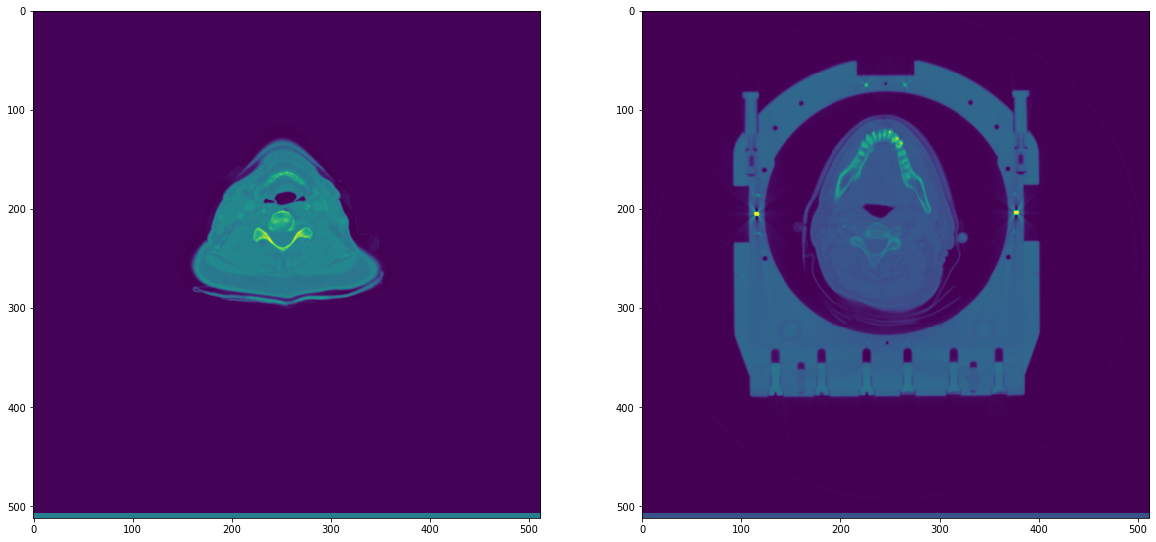

In [242]:
r=67
fig,axes = plt.subplots(1,2,figsize=(20,10))

axes[0].imshow(npazer[r])
axes[1].imshow(npazer_label[r])

In [247]:
filename=r"C:\Users\r778e\Desktop\patient_aug\augmented_label\spatial_aug0_0.0_0.0_0.0_0_5_5_1_.mha"



ct_image = sitk.ReadImage(filename)
npazer = sitk.GetArrayFromImage(ct_image)

In [248]:
filename=r"C:\Users\r778e\Desktop\patient_aug\augmented_label\spatial_aug1_0.0_0.0_0.0_0_5_5_1_.mha"

ct_image = sitk.ReadImage(filename)
npazer_label = sitk.GetArrayFromImage(ct_image)

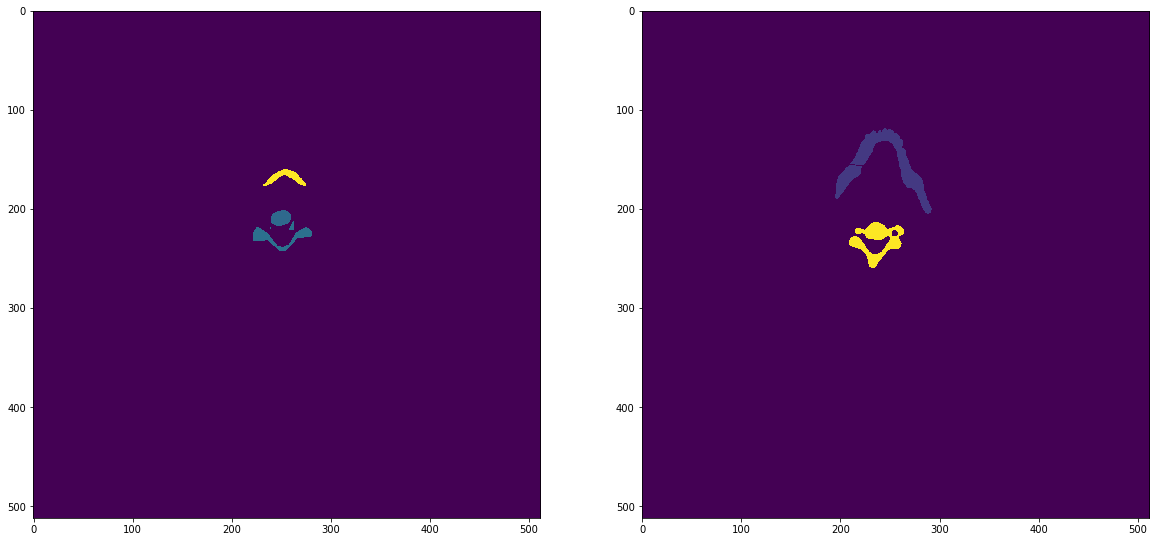

In [249]:
r=67
fig,axes = plt.subplots(1,2,figsize=(20,10))

axes[0].imshow(npazer[r])
axes[1].imshow(npazer_label[r])

In [219]:
np.unique(npazer_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int16)

In [108]:
np.unique(npazer[r,0:10,0:100])

array([-1024], dtype=int16)

In [76]:
np.unique(npa[4,:,500])

array([-1024, -1023, -1022, -1018, -1015, -1011, -1010, -1007, -1005,
       -1000,  -998,  -996,  -995,  -994,  -993,  -990,  -988,  -985,
        -981,  -980,  -979,  -977,  -976,  -971,  -954,  -952,  -948,
        -941,  -940,  -930,  -925,  -919,  -912,  -906,  -726,  -720,
        -707,  -706,  -703,  -700,  -689,  -687,  -680,  -675,  -674,
        -670,  -659,  -644,  -629,  -611,  -604,  -601,  -575,  -525,
        -520,  -448,  -440,  -435,  -409,  -400,  -315,  -301,  -252,
        -191,  -103,   -70,   -49,   -30,   -26,   -21,   -19,    -9,
          -4,     0,     1,     2,     5,     6,     8,    11,    12,
          14,    17,    20,    21,    22,    23,    25,    29,    30,
          34,    38,    42,    44,    47,    53,    63,   103,   105,
         107,   110,   111,   117,   119,   127,   129,   131,   132,
         134,   135,   136,   139,   140,   141,   152,   161,   163],
      dtype=int16)

In [334]:
filename=r"C:\Users\r778e\Desktop\patient_aug\augmented_label\spatial_aug1_0.0_0.0_0.0_0_5_5_1_.mha"

ct_label = sitk.ReadImage(filename)
npazer_label = sitk.GetArrayFromImage(ct_label)


In [333]:
npazer_image = sitk.GetArrayFromImage(patient_3_label)

In [318]:
D,H,W=npazer_image.shape
for d in range(D):
    for h in range(H):
        for w in range(W):
            if npazer_image[d,h,w] == 0:
                npazer_image[d,h,w] = -1024


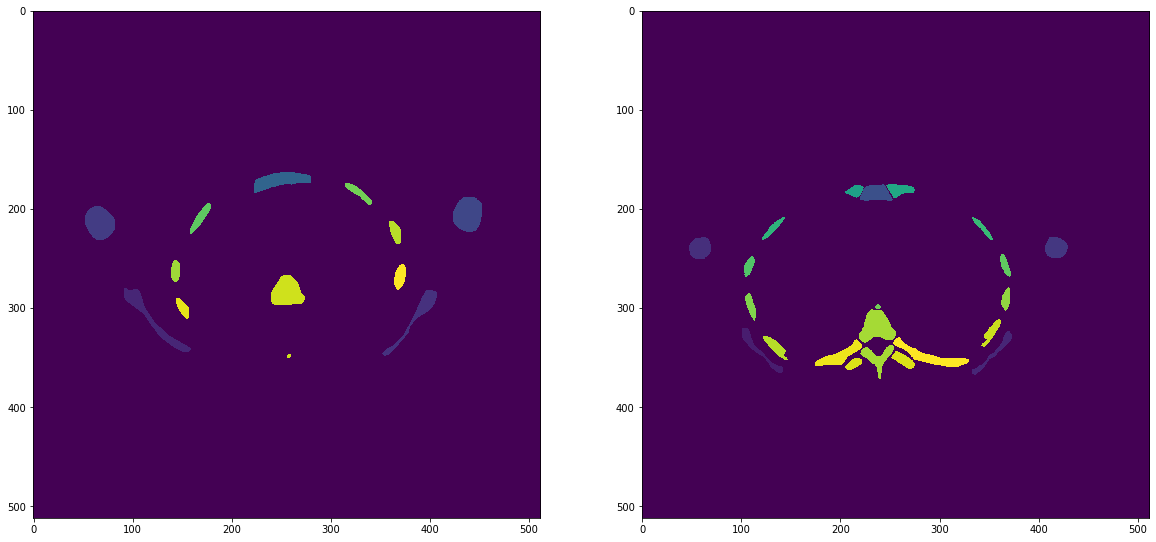

In [335]:
r=7
fig,axes = plt.subplots(1,2,figsize=(20,10))

axes[0].imshow(npazer_image[r])
axes[1].imshow(npazer_label[r])

In [312]:
def write_augmented_data(image_ref,image_array,output_dir,id_patient):
    ct_image=sitk.GetImageFromArray(image_array)
    ct_image.CopyInformation(image_ref)
    sitk.WriteImage(ct_image,os.path.join(output_dir,'data_set_no_augmentation','HeadAndNeck_anonymous-%i.mha')%id_patient)

In [313]:
write_augmented_data(ct_image,npazer,output_dir=r"D:",id_patient=9)

In [30]:
folder_path = r"C:\Users\r778e\Desktop\augmenteddata"

In [31]:
listzer=os.listdir(folder_path)

In [35]:
folder_path = r"C:\Users\r778e\Desktop\augmenteddata"

for path, dirs, files in os.walk(folder_path):
    for filename in files:
        print(filename)

augmenteddata0_AdaptiveHistogramEqualizationImageFilter.mha
augmenteddata0_AdditiveGaussianNoiseImageFilter.mha
augmenteddata0_BilateralImageFilter.mha
augmenteddata0_DiscreteGaussianImageFilter.mha
augmenteddata0_MedianImageFilter.mha
augmenteddata0_SaltAndPepperNoiseImageFilter.mha
augmenteddata0_ShotNoiseImageFilter.mha
augmenteddata0_SmoothingRecursiveGaussianImageFilter.mha
augmenteddata0_SpeckleNoiseImageFilter.mha
augmenteddata1_AdaptiveHistogramEqualizationImageFilter.mha
augmenteddata1_AdditiveGaussianNoiseImageFilter.mha
augmenteddata1_BilateralImageFilter.mha
augmenteddata1_DiscreteGaussianImageFilter.mha
augmenteddata1_MedianImageFilter.mha
augmenteddata1_SaltAndPepperNoiseImageFilter.mha
augmenteddata1_ShotNoiseImageFilter.mha
augmenteddata1_SmoothingRecursiveGaussianImageFilter.mha
augmenteddata1_SpeckleNoiseImageFilter.mha


In [35]:
folder_path = r"C:\Users\r778e\Desktop\augmenteddata"

for path, dirs, files in os.walk(folder_path):
    for filename in files:
        print(filename)

augmenteddata0_AdaptiveHistogramEqualizationImageFilter.mha
augmenteddata0_AdditiveGaussianNoiseImageFilter.mha
augmenteddata0_BilateralImageFilter.mha
augmenteddata0_DiscreteGaussianImageFilter.mha
augmenteddata0_MedianImageFilter.mha
augmenteddata0_SaltAndPepperNoiseImageFilter.mha
augmenteddata0_ShotNoiseImageFilter.mha
augmenteddata0_SmoothingRecursiveGaussianImageFilter.mha
augmenteddata0_SpeckleNoiseImageFilter.mha
augmenteddata1_AdaptiveHistogramEqualizationImageFilter.mha
augmenteddata1_AdditiveGaussianNoiseImageFilter.mha
augmenteddata1_BilateralImageFilter.mha
augmenteddata1_DiscreteGaussianImageFilter.mha
augmenteddata1_MedianImageFilter.mha
augmenteddata1_SaltAndPepperNoiseImageFilter.mha
augmenteddata1_ShotNoiseImageFilter.mha
augmenteddata1_SmoothingRecursiveGaussianImageFilter.mha
augmenteddata1_SpeckleNoiseImageFilter.mha


In [ ]:
os.path.abspath(listzer[0])

[]

In [24]:
folder_path = r"C:\Users\r778e\Desktop\augmenteddata"

for path, dirs, files in os.walk(folder_path):
    for filename in files:
        print(filename)

augmenteddata0_AdaptiveHistogramEqualizationImageFilter.mha
augmenteddata0_AdditiveGaussianNoiseImageFilter.mha
augmenteddata0_BilateralImageFilter.mha
augmenteddata0_DiscreteGaussianImageFilter.mha
augmenteddata0_MedianImageFilter.mha
augmenteddata0_SaltAndPepperNoiseImageFilter.mha
augmenteddata0_ShotNoiseImageFilter.mha
augmenteddata0_SmoothingRecursiveGaussianImageFilter.mha
augmenteddata0_SpeckleNoiseImageFilter.mha


In [32]:
images=[]
for f in listzer:
    ct_image=sitk.ReadImage(os.path.join(input_data_dir,f)) 
    image=sitk.GetArrayFromImage(ct_image)
    images.append(image)
    
    

In [ ]:
images[0]

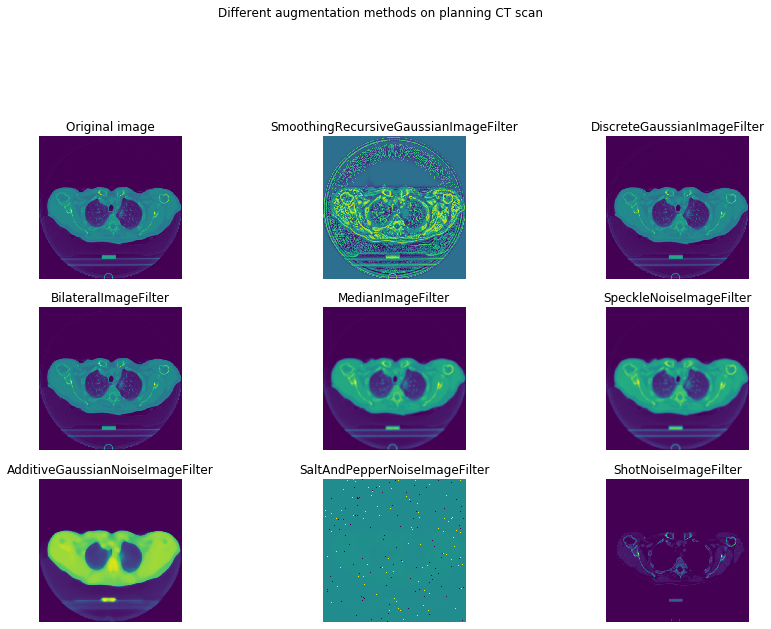

In [41]:
# Visualise using matplotlib
f, axarr = plt.subplots(3, 3, figsize=(15,10));
f.suptitle('Different augmentation methods on planning CT scan')
z=46
axarr[0,0].imshow(npa[z,:,:])
axarr[0,0].axis('off')
axarr[0,0].set_title('Original image')

axarr[0,1].imshow(np.squeeze(images[0][z,:,:]))
axarr[0,1].axis('off')
axarr[0,1].set_title('SmoothingRecursiveGaussianImageFilter')

axarr[0,2].imshow(np.squeeze(images[1][z,:,:]))
axarr[0,2].axis('off')
axarr[0,2].set_title('DiscreteGaussianImageFilter')

axarr[1,0].imshow(np.squeeze(images[2][z,:,:]))
axarr[1,0].axis('off')
axarr[1,0].set_title('BilateralImageFilter')

axarr[1,1].imshow(np.squeeze(images[3][z,:,:]))
axarr[1,1].axis('off')
axarr[1,1].set_title('MedianImageFilter')

axarr[2,0].imshow(np.squeeze(images[4][z,:,:]))
axarr[2,0].axis('off')
axarr[2,0].set_title('AdditiveGaussianNoiseImageFilter')

axarr[2,1].imshow(np.squeeze(images[5][z,:,:]))
axarr[2,1].axis('off')
axarr[2,1].set_title('SaltAndPepperNoiseImageFilter')
    
axarr[2,2].imshow(np.squeeze(images[6][z,:,:]))
axarr[2,2].axis('off')
axarr[2,2].set_title('ShotNoiseImageFilter')

axarr[1,2].imshow(np.squeeze(images[7][z,:,:]))
axarr[1,2].axis('off')
axarr[1,2].set_title('SpeckleNoiseImageFilter')
    
f.subplots_adjust(wspace=0.05, top=0.8)
plt.show();



In [266]:
def write_augmented_data(image_ref,image_array,output_dir):
    ct_image=sitk.GetImageFromArray(image_array)
    ct_image.CopyInformation(image_ref)
    sitk.WriteImage(ct_image,os.path.join(output_dir, 'patient_aug','.mha'))

In [267]:
write_augmented_data(ct_image,npazer,output_dir=r"C:\Users\r778e\Desktop")